In [1]:
import time
from uuid import UUID
from importlib import reload

import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import osmnx as ox
import numpy as np

from spad.etl import read_csv
from spad import bounding_box as bb
from spad import map_matching as mm

In [2]:
fname = "/mnt/tod/data/gridwise-gps-locations/cmu_honda_clb_oct_1_15_2019.csv"

In [3]:
trajectories = read_csv(fname)

/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
driver = UUID("ff1d999c-5fc9-465d-af6c-8e8ef1343376")
trajectory = trajectories.xs((driver, 432323), level=('driver_id', 'shift_id')).sort_index()

In [5]:
single_trajectory = trajectory[trajectory.segment_id == 1]
len(single_trajectory)

145

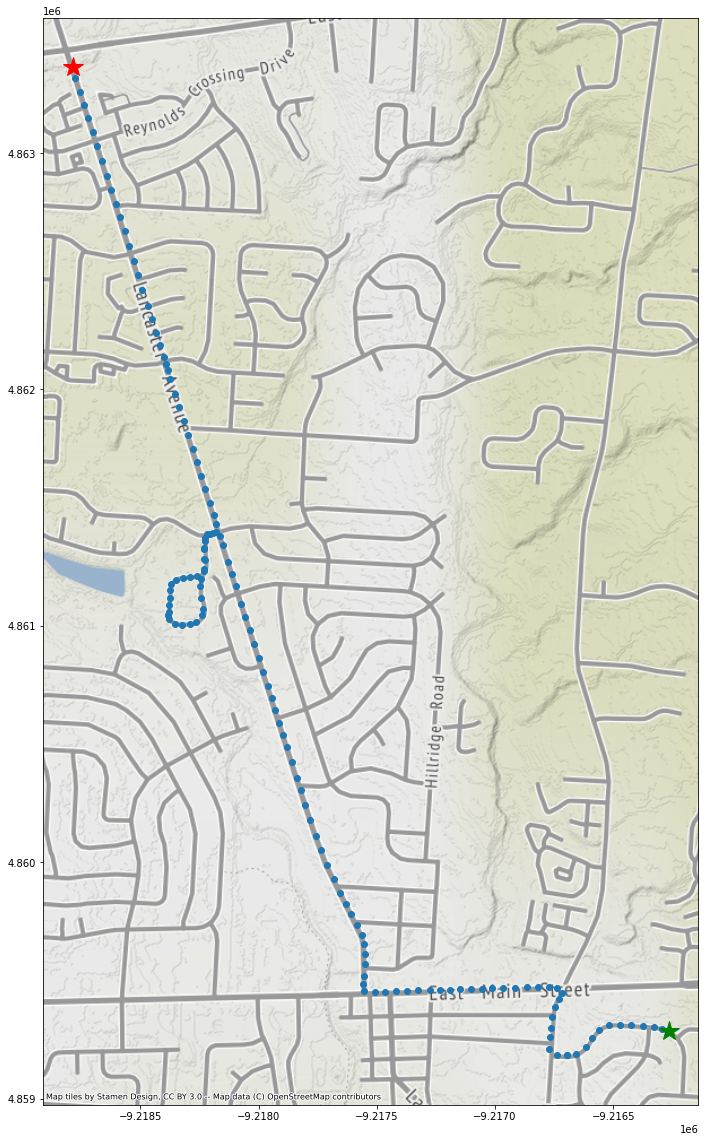

In [6]:
st = single_trajectory.to_crs(epsg=3857)
ax = st.plot(figsize=(12, 20))
ctx.add_basemap(ax)
start = st.iloc[0].geometry
ax.plot(start.x, start.y, '*g', markersize=20, zorder=1)
end = st.iloc[-1].geometry
ax.plot(end.x, end.y, '*r', markersize=20, zorder=1)

In [7]:
bbox = bb.BoundingBox.from_geodataframe(single_trajectory, 0.01)
crs = bbox.get_utm()
g = ox.project_graph(bbox.to_osmnx(), to_crs=crs)

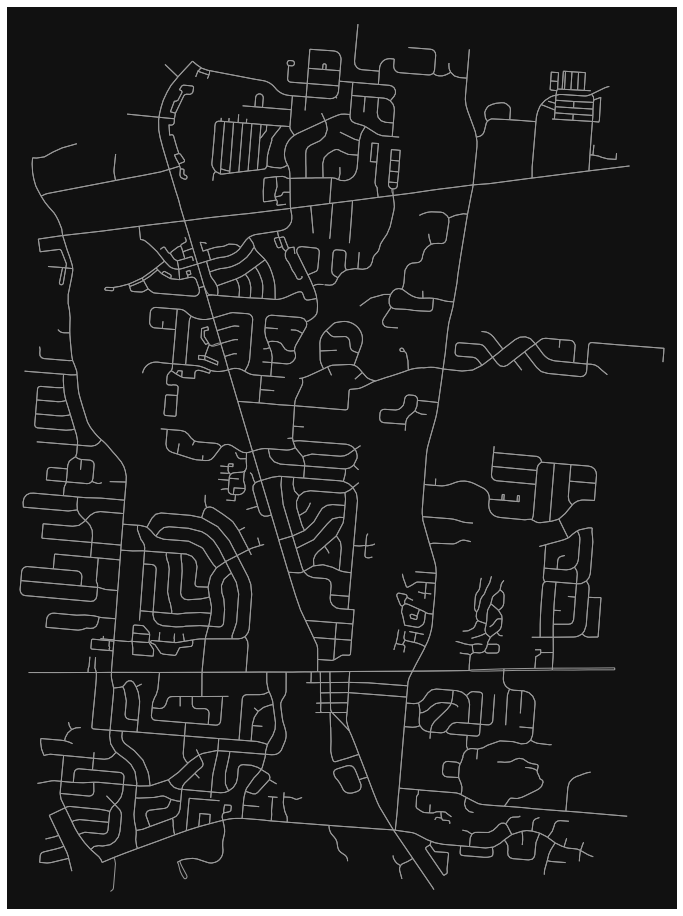

(<Figure size 864x1440 with 1 Axes>, <AxesSubplot:>)

In [8]:
ox.plot_graph(g, node_size=0, figsize=(12, 20))

In [9]:
gps_trajectory = single_trajectory.to_crs(crs)

In [10]:
nodes, links = ox.graph_to_gdfs(g)

In [11]:
assert links.crs == g.graph['crs'] == gps_trajectory.crs

In [12]:
neighborhood = mm.link_neighborhood(links, gps_trajectory, 200)

In [13]:
row_id = 3528454

In [14]:
neighborhood.loc[row_id].sort_values('distance_to_link')[['distance_to_link', 'offset']].head()

distance_to_link      offset
timestamp               u         v         key                              
2019-10-09 08:56:25.997 230029575 230347791 0            1.299810   66.249541
                        230347791 230029575 0            1.299810   33.522956
                                  229922833 0           33.548146    0.000000
                        229922833 230347791 0           33.548146  193.432906
                        229922837 230347791 0           33.548146  329.061201

In [15]:
neighborhood.loc[row_id+1].sort_values('distance_to_link')[['distance_to_link', 'offset']].head()

distance_to_link     offset
timestamp               u         v         key                             
2019-10-09 08:56:28.997 230347791 230029575 0            1.792369  56.690686
                        230029575 230347791 0            1.792369  43.081811
                        229845134 230029575 0           43.060484  87.574724
                        230029575 229845134 0           43.060484   1.185139
                                  229932827 0           43.076790   0.000000

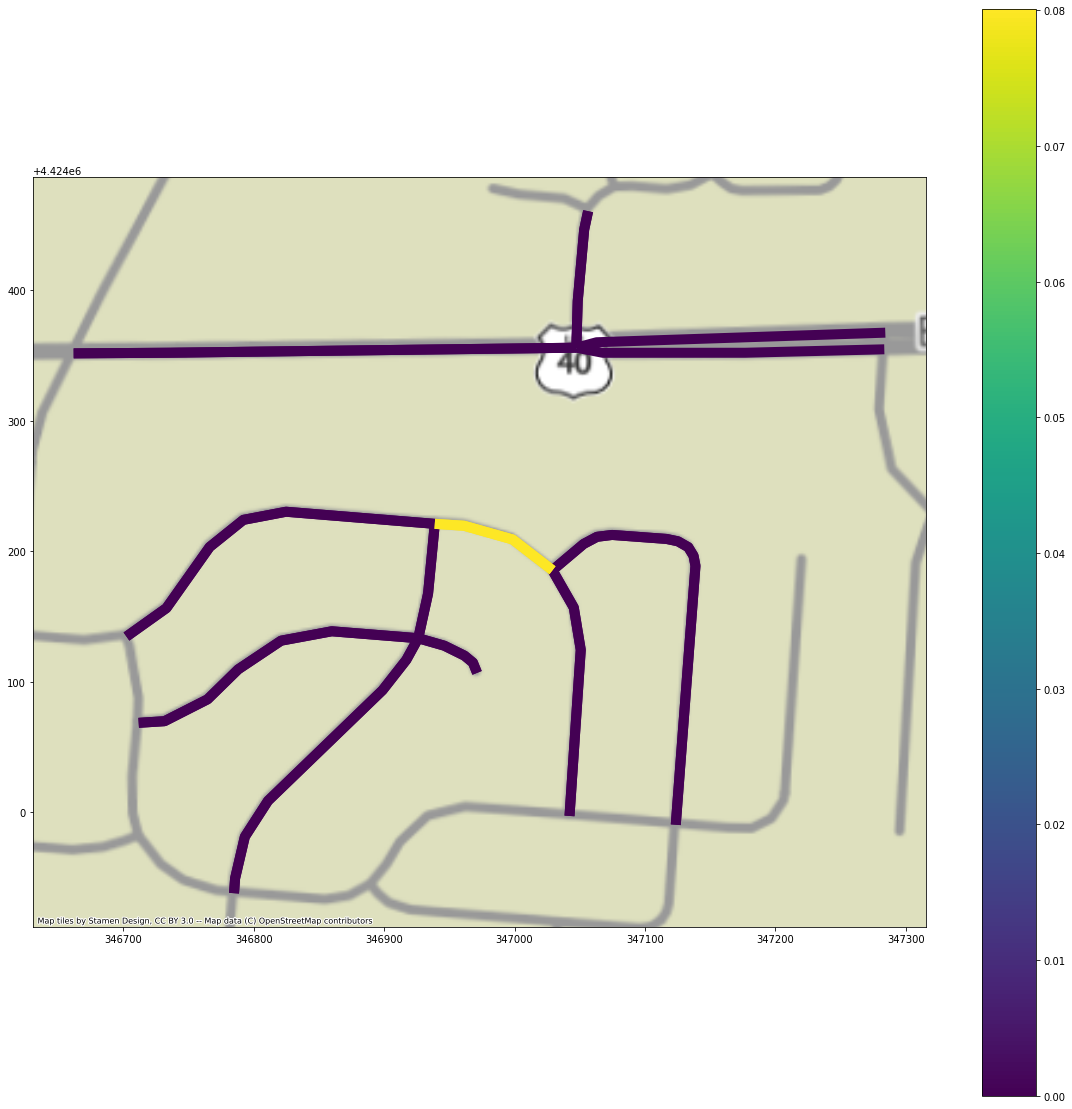

In [16]:
emit_p = mm.emission_probabilities(neighborhood, 'accuracy')

ax = neighborhood.set_geometry('link_geometry').loc[row_id].plot(emit_p.loc[row_id], linewidth=10, legend=True, figsize=(20, 20))
ctx.add_basemap(ax, crs=neighborhood.crs.srs, zoom=16)


u->v length = 99.77249715938107==99.59899999999999; v->u length = 99.77249715938107==99.59899999999999
u->v offset = 66.24954095603945; v->u offset = 33.52295620334162; total= 99.77249715938107


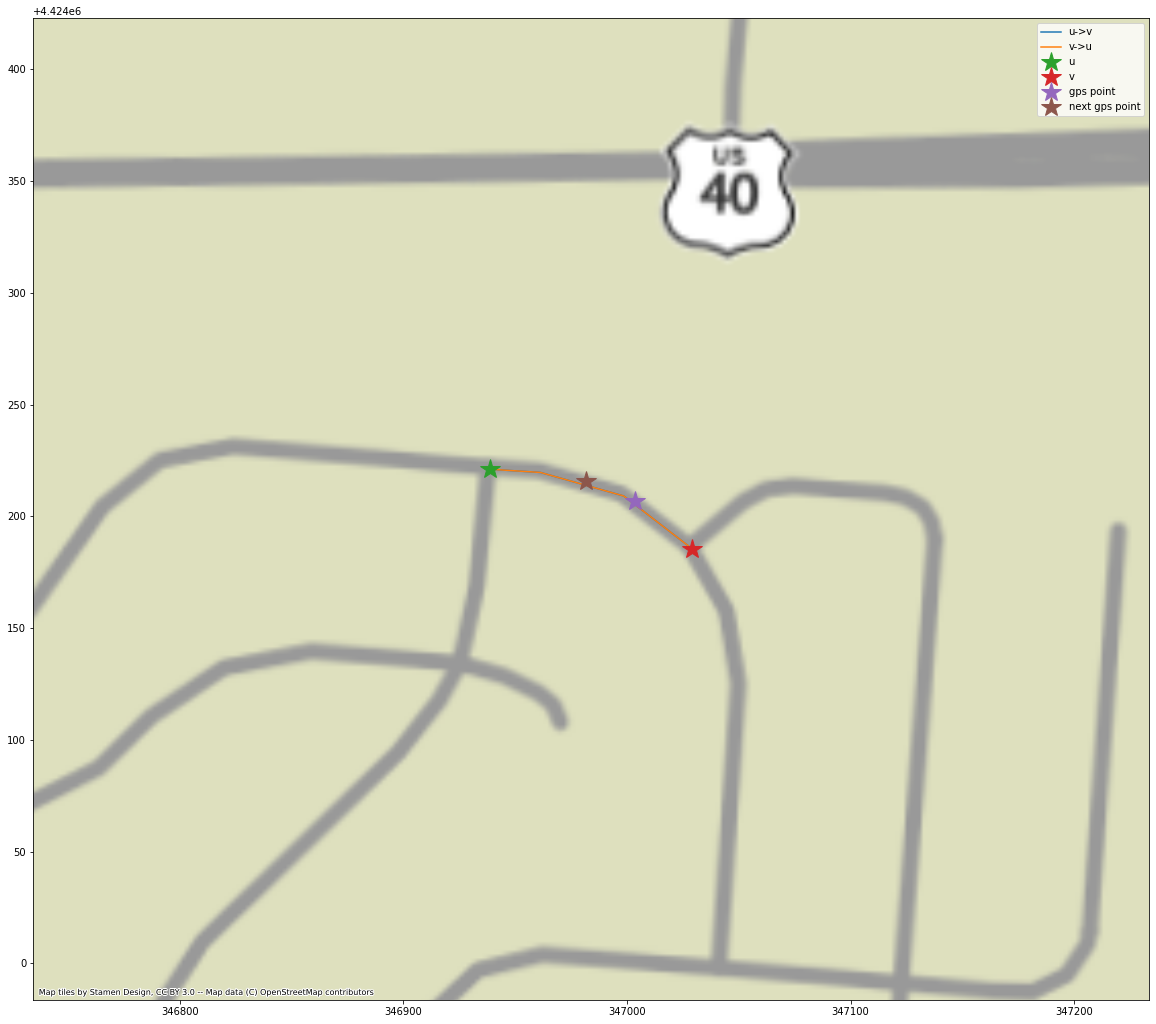

In [17]:
u = 230029575
v = 230347791
link_1 = g.get_edge_data(u, v, 0)
link_2 = g.get_edge_data(v, u, 0)

link_geom_1 = link_1['geometry']

offset_1 = neighborhood.xs((row_id, u, v, 0), level=('rowid', 'u', 'v', 'key')).offset.values[0]

link_geom_2 = g.get_edge_data(v, u, 0)['geometry']
offset_2 = neighborhood.xs((row_id, v, u, 0), level=('rowid', 'u', 'v', 'key')).offset.values[0]

print(f"u->v length = {link_geom_1.length}=={link_1['length']}; v->u length = {link_geom_2.length}=={link_2['length']}")
print(f"u->v offset = {offset_1}; v->u offset = {offset_2}; total= {offset_1 + offset_2}")

u_data = g.nodes[u]
v_data = g.nodes[v]

fig, ax = plt.subplots(figsize=(20,20))
plt.plot(*link_geom_1.xy, label=f"u->v")
plt.plot(*link_geom_2.xy, label=f"v->u")
plt.plot(u_data['x'], u_data['y'], '*', markersize=20, label=f"u")
plt.plot(v_data['x'], v_data['y'], '*', markersize=20,label=f"v")
plt.plot(*neighborhood.loc[3528454].geometry.iloc[0].xy, '*', markersize=20, label='gps point')
plt.plot(*neighborhood.loc[3528455].geometry.iloc[0].xy, '*', markersize=20, label='next gps point')
buf = 200
l, r = ax.get_xlim()
b, t = ax.get_ylim()
ax.set_xlim(l-buf, r+buf)
ax.set_ylim(b-buf, t+buf)
ctx.add_basemap(ax, crs=neighborhood.crs.srs, zoom=16)
plt.legend()
None

In [18]:
uv1 = neighborhood.xs((row_id, u, v, 0), level=('rowid', 'u', 'v', 'key'), drop_level=False).iloc[0]
vu1 = neighborhood.xs((row_id, v, u, 0), level=('rowid', 'u', 'v', 'key'), drop_level=False).iloc[0]
uv2 = neighborhood.xs((row_id+1, u, v, 0), level=('rowid', 'u', 'v', 'key'), drop_level=False).iloc[0]
vu2 = neighborhood.xs((row_id+1, v, u, 0), level=('rowid', 'u', 'v', 'key'), drop_level=False).iloc[0]

In [19]:
spc = mm.ShortestPathCalculator(g, allow_reverse=True)
print(spc.distance(uv1, uv2), uv1.geometry.distance(uv2.geometry))
print(spc.distance(uv1, vu2), uv1.geometry.distance(vu2.geometry))
print(spc.distance(vu1, vu2), vu1.geometry.distance(vu2.geometry))
print(spc.distance(vu1, uv2), vu1.geometry.distance(uv2.geometry))

-23.167729731794516 23.41778848804094
90.21364213847775 23.41778848804094
23.16772973179451 23.41778848804094
109.3313521802844 23.41778848804094


In [20]:
geom_col = gps_trajectory.geometry.name
print(-np.log(mm.transition_probabilities(spc, geom_col, uv1, uv2)))
print(-np.log(mm.transition_probabilities(spc, geom_col, uv1, vu2)))
print(-np.log(mm.transition_probabilities(spc, geom_col, vu1, vu2)))
print(-np.log(mm.transition_probabilities(spc, geom_col, vu1, uv2)))

46.58551821983546
66.79585365043681
0.2500587562464318
85.91356369224346


In [21]:
spc = mm.ShortestPathCalculator(g, allow_reverse=False)

In [22]:
t0 = time.time()
path = mm.map_match(links, gps_trajectory, spc, threshold=20)
print(f"Matched GPS trace to network in {time.time() - t0} seconds.")

Matched GPS trace to network in 1.474419355392456 seconds.


In [23]:
nodes = []
for idx in path:
    u, v, _ = mm.get_link_key(idx)
    if nodes:
        # if there are nodes in the list so far
        if (u, v) == tuple(nodes[-2:]):
            # ignore repeat edges
            continue
        else:
            v0 = nodes.pop()
            if g.number_of_edges(v0, u):
                # if there is an edge from v0 to u add it
                nodes.append(v0)
                nodes.append(u)
            else:
                # else add the shortest path
                nodes.extend(ox.shortest_path(g, v0, u))
            nodes.append(v)
    else:
        # just add the link
        nodes.append(u)
        nodes.append(v)

<AxesSubplot:>

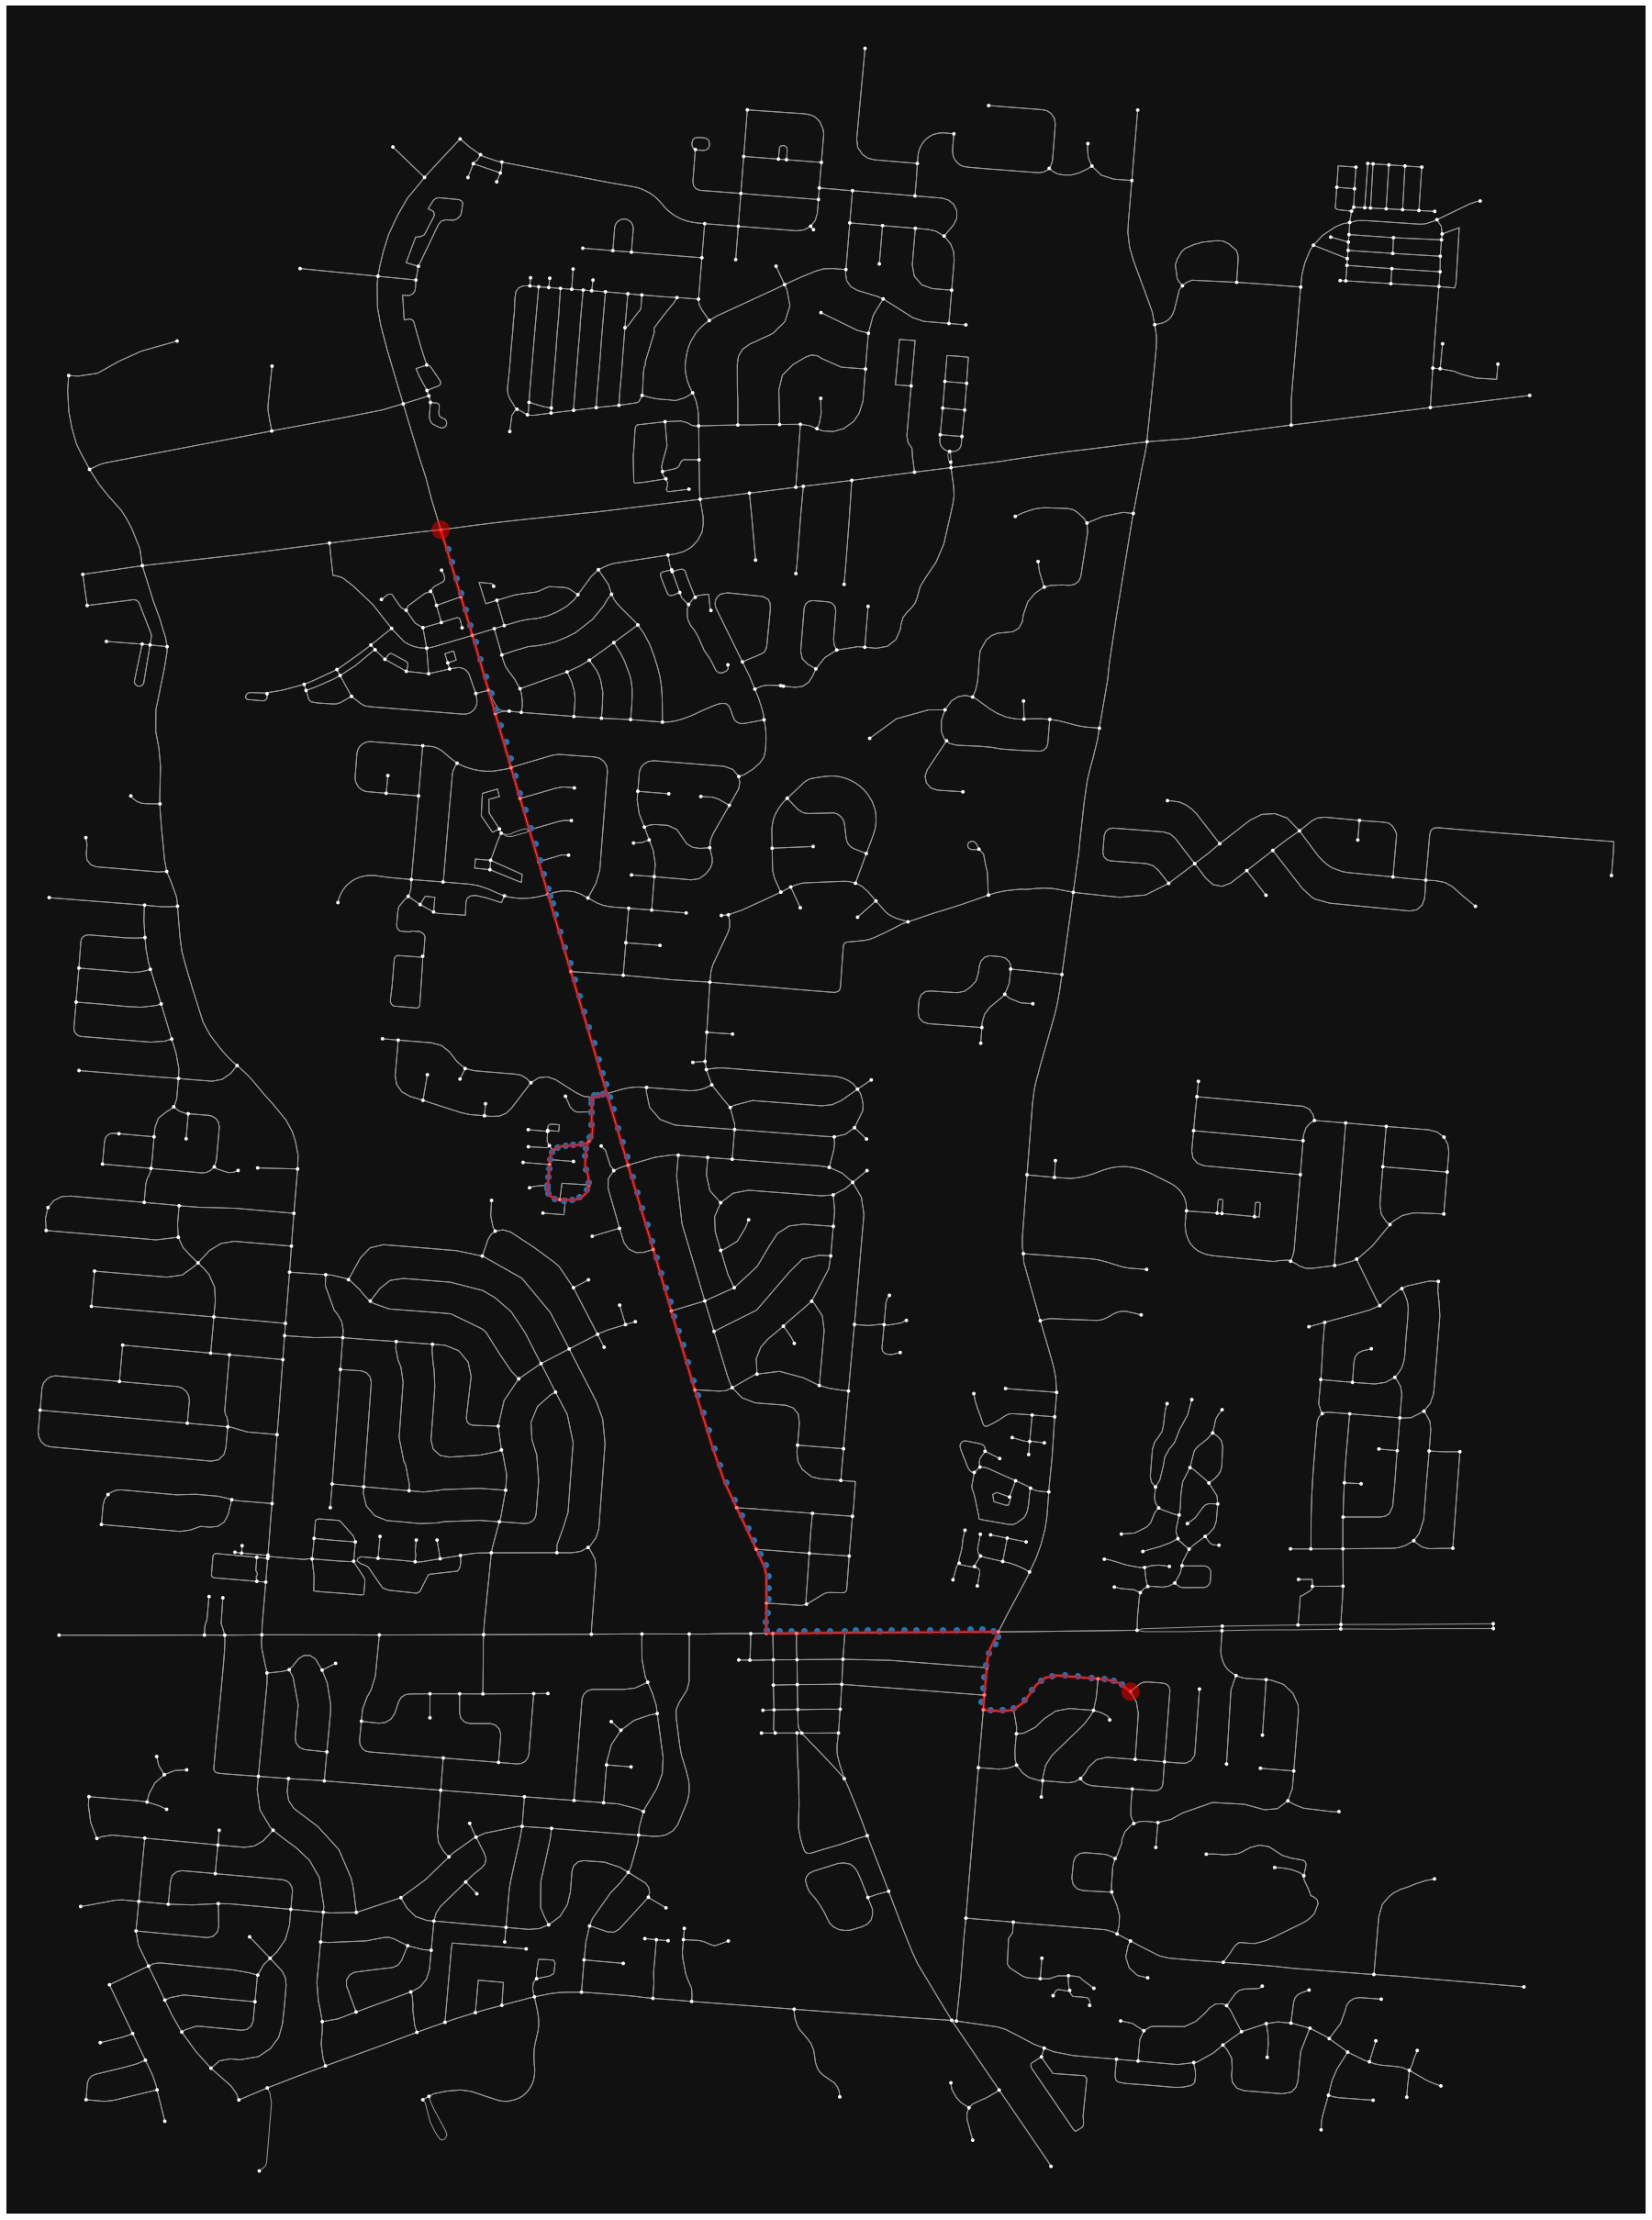

In [24]:
fig, ax = ox.plot_graph_route(g, nodes, orig_dest_size=400, figsize=(32,64), show=False, close=False)
gps_trajectory.plot(ax=ax, zorder=1)